In [1]:
import os 
import pandas as pd
from pyCaLProblem import CarbProblem
from pyCaLPlant import Pinch_point_analyzer
import geatpy as ea
import numpy as np
import shutil
import proplot as pplot

In [2]:
Tcarbs=[600]
cao_conversions=[0.2]
T_water_reactor_out=[80]
# Tcarbs=[600,630,660]
# cao_conversions=[0.2,0.3,0.4,0.5]
# T_water_reactor_out=[80,150]
flue_gas_composition=dict()
flue_gas_composition["co2"]=0.1338
flue_gas_composition["o2"]=0.0384
flue_gas_composition["n2"]=0.6975
vol_rate_flue_gas=6000/3600
decarbonized_rate=0.9
T_flue_gas=40

all_plant_results={}
all_best_variables={}
pinch_point_analysis_folder="./ppa_results"
convergence_plots_folder="./convergence_plots"
folders=[pinch_point_analysis_folder,convergence_plots_folder]
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)
    else:
        shutil.rmtree(folder)
        os.mkdir(folder)

for Tcarb in Tcarbs:
    for X in cao_conversions:
        for Tw in T_water_reactor_out:
            print(f"solving the case: Tcarb = {Tcarb}, Tw = {Tw}, X = {X}")
            case_id=f"Tcarb={Tcarb}_Tw={Tw}_X={X}"
            print(f"case_id: {case_id}")
            parameters={}
            parameters["T_carb"]=Tcarb
            parameters["cao_conversion"]=X
            parameters["flue_gas_composition"]=flue_gas_composition
            parameters["vol_rate_flue_gas"]=vol_rate_flue_gas
            parameters["decarbonized_rate"]=decarbonized_rate
            parameters["T_flue_gas"]=T_flue_gas
            parameters["T_water_reactor_out"]=Tw
            
            problem = CarbProblem(parameters)
            algorithm = ea.soea_DE_currentToBest_1_bin_templet(problem,
                                            ea.Population(Encoding='RI', NIND=30),
                                            MAXGEN=200,  # 最大进化代数。
                                            logTras=1, #,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                            trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                            maxTrappedCount=100)  # # 进化停滞计数器最大上限值。
            algorithm.mutOper.F=0.95 #变异概率
            algorithm.recOper.XOVR = 0.95  # 重组概率

            # 求解
            res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=True, saveFlag=False)
            print(res)
            best_vars=res["Vars"]
            all_best_variables[case_id]=best_vars[0]

            # copy the trace plot to folder
            shutil.copyfile("./Trace Plot.svg",f"{convergence_plots_folder}/{case_id}.svg")
            
            # solve the plant status with the best choice   
            input={}
            input["T_flue_gas_reactor_in"]=best_vars[0,0]
            input["T_cao_reactor_in"]=best_vars[0,1]
            input["T_water_reactor_in"]=best_vars[0,2]
            plant_results=problem._plant.solve(input)
            print(f"plant results: {plant_results}")
            all_plant_results[case_id]=plant_results

            # save csv files for pinch point analysis
            ppa=Pinch_point_analyzer(plant_results)
            ppa.write_pyPinch_data_csv(f"{pinch_point_analysis_folder}/{case_id}.csv")
        
df_plant_results=pd.DataFrame(all_plant_results).T
df_plant_results.to_csv("plant_results.csv")

df_best_variables = pd.DataFrame(all_best_variables, index=["T_flue_gas_reactor_in",
                                                            "T_cao_reactor_in", "T_water_reactor_in"]).T
df_best_variables.to_csv("best_variables.csv")
print("Succeed to output the results")

solving the case: Tcarb = 600, Tw = 80, X = 0.2
case_id: Tcarb=600_Tw=80_X=0.2
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   30   | 7.58299E-01 | 7.58299E-01 | -1.90759E-01| -3.21480E+00| 7.80021E-01 
 1 |   60   | 9.53488E-01 | 9.53488E-01 | 3.30598E-01 | -8.39529E-01| 4.68240E-01 
 2 |   90   | 9.53488E-01 | 9.53488E-01 | 5.67603E-01 | -8.39529E-01| 4.75052E-01 
 3 |  120   | 9.56770E-01 | 9.56770E-01 | 8.81774E-01 | 2.31513E-01 | 1.50108E-01 
 4 |  150   | 9.73093E-01 | 9.73093E-01 | 9.41513E-01 | 9.03649E-01 | 1.73405E-02 
 5 |  180   | 9.76658E-01 | 9.76658E-01 | 9.48692E-01 | 9.03649E-01 | 1.89837E-02 
 6 |  210   | 9.76658E-01 | 9.76658E-01 | 9.59264E-01 | 9.24816E-01 | 1.27039E-02 
 7 |  240   | 9.78036E-01 | 9.78036E-01 | 9.65155E-01 | 9.24816E-01 | 1.18809E-02 
 8 |  270   | 9.78036E-01 | 9.78036E-01 | 9.69516E-01 | 9.36533E-01 | 9.08797E-03 
 9 |  30

In [1]:
df_pEff=pd.read_csv("./plant_results.csv")
df_pEff1=df_pEff[df_pEff["T_water_reactor_out"]==80]
with pplot.rc.context({"grid": False}):
    fig, ax = pplot.subplots(aspect=(1, 1), axwidth=3)
    Tcarb=df_pEff1["T_carb"]
    X=df_pEff1["cao_conversion"]
    pEff=df_pEff1["plant_eff"]*100
    ax.plot(X[Tcarb==600].reset_index(drop=True),pEff[Tcarb==600].reset_index(drop=True),label="T = 600",linestyle="--",marker="^")
    ax.plot(X[Tcarb==630].reset_index(drop=True),pEff[Tcarb==630].reset_index(drop=True),label="T = 630",linestyle="--",marker="s")
    ax.plot(X[Tcarb==660].reset_index(drop=True),pEff[Tcarb==660].reset_index(drop=True),label="T = 660",linestyle="--",marker="o")
    ax.format(xlabel="CaO activity",ylabel="plant efficiency (%)")
    # ax.set_ylim([38,46.5])
    ax.legend()
    fig.savefig("plant_efficiency_Tw=80.jpg",bbox_inches='tight')


NameError: name 'pd' is not defined

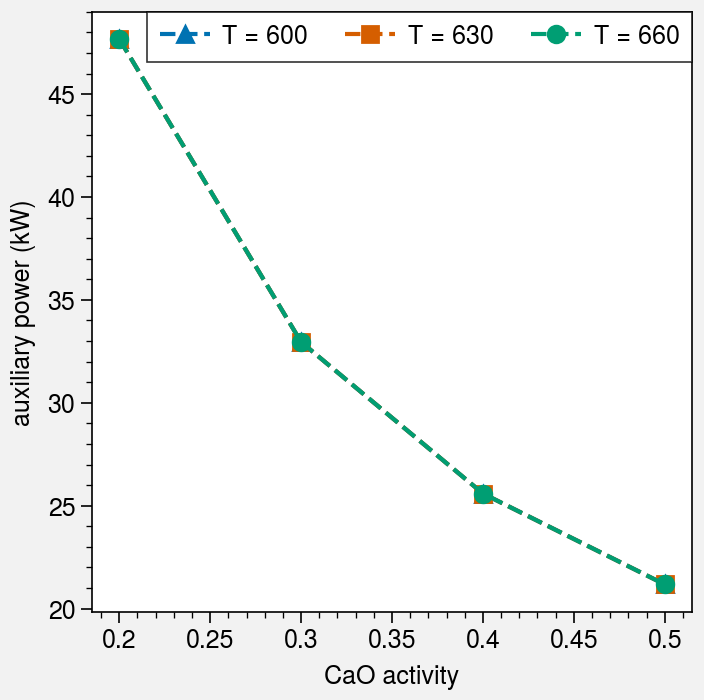

In [ ]:
with pplot.rc.context({"grid": False}):
    fig, ax = pplot.subplots(aspect=(1, 1), axwidth=3)
    Tcarb=df_pEff1["T_carb"]
    X=df_pEff1["cao_conversion"]
    power=-df_pEff1["total_auxiliary_power"]/1000
    ax.plot(X[Tcarb==600].reset_index(drop=True),power[Tcarb==600].reset_index(drop=True),label="T = 600",linestyle="--",marker="^")
    ax.plot(X[Tcarb==630].reset_index(drop=True),power[Tcarb==630].reset_index(drop=True),label="T = 630",linestyle="--",marker="s")
    ax.plot(X[Tcarb==660].reset_index(drop=True),power[Tcarb==660].reset_index(drop=True),label="T = 660",linestyle="--",marker="o")
    ax.format(xlabel="CaO activity",ylabel="auxiliary power (kW)")
    # ax.set_ylim([38,46.5])
    ax.legend()
    fig.savefig("power_Tw=80.jpg",bbox_inches='tight')

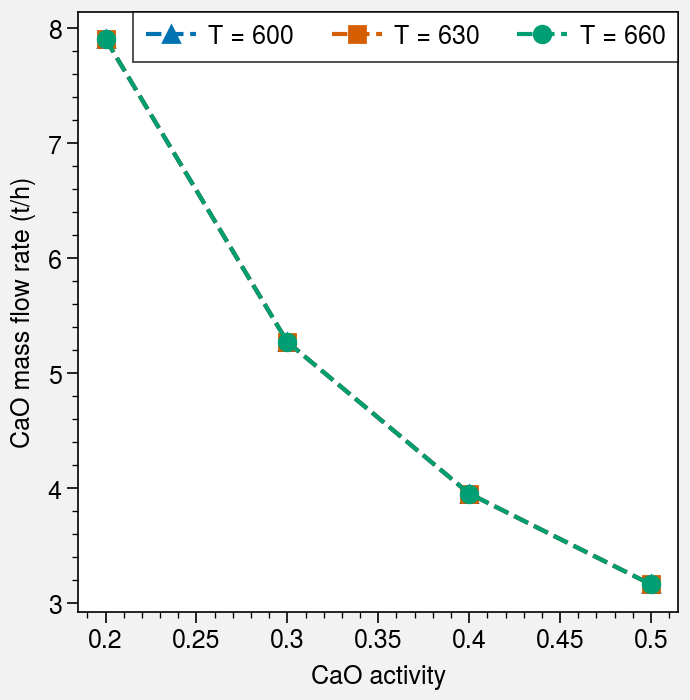

In [ ]:
with pplot.rc.context({"grid": False}):
    fig, ax = pplot.subplots(aspect=(1, 1), axwidth=3)
    Tcarb=df_pEff1["T_carb"]
    X=df_pEff1["cao_conversion"]
    mass_cao=df_pEff1["m_cao_in"]*3600/1000
    ax.plot(X[Tcarb==600].reset_index(drop=True),mass_cao[Tcarb==600].reset_index(drop=True),label="T = 600",linestyle="--",marker="^")
    ax.plot(X[Tcarb==630].reset_index(drop=True),mass_cao[Tcarb==630].reset_index(drop=True),label="T = 630",linestyle="--",marker="s")
    ax.plot(X[Tcarb==660].reset_index(drop=True),mass_cao[Tcarb==660].reset_index(drop=True),label="T = 660",linestyle="--",marker="o")
    ax.format(xlabel="CaO activity",ylabel="CaO mass flow rate (t/h)")
    # ax.set_ylim([38,46.5])
    ax.legend()
    fig.savefig("mass_cao_Tw=80.jpg",bbox_inches='tight')

In [ ]:
with pplot.rc.context({"grid": False}):
    fig, ax = pplot.subplots(aspect=(1, 1), axwidth=3)
    Tcarb=df_pEff1["T_carb"]
    X=df_pEff1["cao_conversion"]
    mw=df_pEff1["m_water_in"]*3600/1000
    ax.plot(X[Tcarb==600].reset_index(drop=True),mw[Tcarb==600].reset_index(drop=True),label="T = 600",linestyle="--",marker="^")
    ax.plot(X[Tcarb==630].reset_index(drop=True),mw[Tcarb==630].reset_index(drop=True),label="T = 630",linestyle="--",marker="s")
    ax.plot(X[Tcarb==660].reset_index(drop=True),mw[Tcarb==660].reset_index(drop=True),label="T = 660",linestyle="--",marker="o")
    ax.format(xlabel="CaO activity",ylabel="mass flow rate of hot water (t/h)")
    # ax.set_ylim([38,46.5])
    ax.legend()
    fig.savefig("hot_water_Tw=80.jpg",bbox_inches='tight')

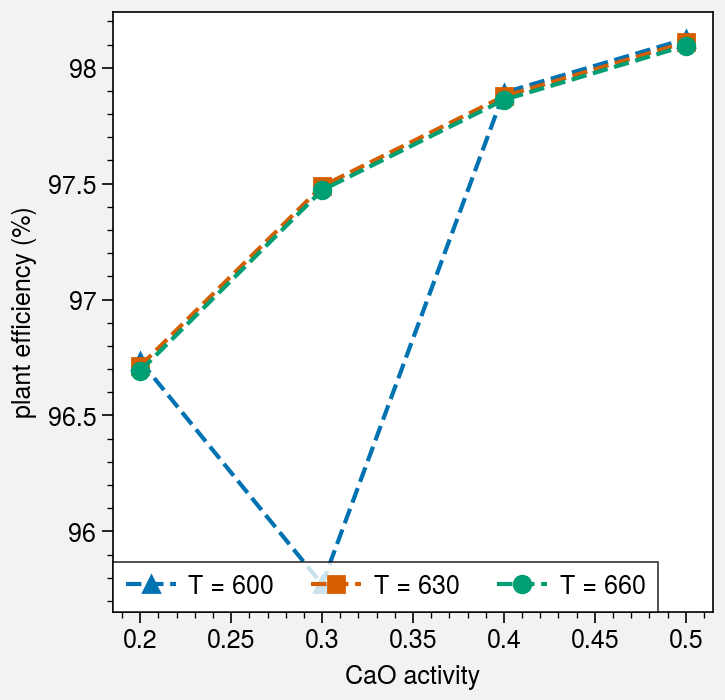

In [ ]:
df_pEff=pd.read_csv("./plant_results.csv")
df_pEff2=df_pEff[df_pEff["T_water_reactor_out"]==150]
with pplot.rc.context({"grid": False}):
    fig, ax = pplot.subplots(aspect=(1, 1), axwidth=3)
    Tcarb=df_pEff2["T_carb"]
    X=df_pEff2["cao_conversion"]
    pEff=df_pEff2["plant_eff"]*100
    ax.plot(X[Tcarb==600].reset_index(drop=True),pEff[Tcarb==600].reset_index(drop=True),label="T = 600",linestyle="--",marker="^")
    ax.plot(X[Tcarb==630].reset_index(drop=True),pEff[Tcarb==630].reset_index(drop=True),label="T = 630",linestyle="--",marker="s")
    ax.plot(X[Tcarb==660].reset_index(drop=True),pEff[Tcarb==660].reset_index(drop=True),label="T = 660",linestyle="--",marker="o")
    ax.format(xlabel="CaO activity",ylabel="plant efficiency (%)")
    # ax.set_ylim([38,46.5])
    ax.legend()
    fig.savefig("plant_efficiency_Tw=150.jpg",bbox_inches='tight')
